# Ligand-based screening 

Your task here is to implement a virtual screening pipeline for unknown compounds using a machine learning approach. 

In [1]:
# Do not forget to import the needed libraries
#data handling
import numpy as np
import pandas as pd

# chemistry
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools, DataStructs, rdFMCS
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.ML.Cluster import Butina

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

ImportError: dlopen(/Users/dimei.wu/mambaforge/envs/py310_aisem2023/lib/python3.10/site-packages/rdkit/rdBase.so, 0x0002): tried: '/Users/dimei.wu/mambaforge/envs/py310_aisem2023/lib/python3.10/site-packages/rdkit/rdBase.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/dimei.wu/mambaforge/envs/py310_aisem2023/lib/python3.10/site-packages/rdkit/rdBase.so' (no such file), '/Users/dimei.wu/mambaforge/envs/py310_aisem2023/lib/python3.10/site-packages/rdkit/rdBase.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))

### Task 1: Data Preparation
To make the ML part easier for you, we have prepared an EGFR dataset for training (`./data/ChEMBL25_activities_EGFR.csv`). Your task is to predict whether a compound is active or not. For the model, you will encode your compounds using fingerprints. Like before, first read in the data into a data frame, then calculate the Morgan fingerprints for all given compounds. 


In [7]:
# read in file 
df=pd.read_csv('./data/ChEMBL25_activities_EGFR.csv')
df.drop(['IC50','units','Unnamed: 0'], axis=1, inplace=True)
df

,chembl_id,canonical_smiles,pIC50
0,CHEMBL207869,Fc1cccc(COc2ccc(Nc3ncncc3C#Cc4ncccn4)cc2Cl)c1,7.113509
1,CHEMBL3940060,Fc1ccc(Nc2ncnc3cc4OC(=O)N(CCOC(=O)CCl)c4cc23)c...,6.481486
2,CHEMBL3678951,CC(C)n1c(Nc2cccc(c2)C(F)(F)F)nc3cnc(Nc4ccc(cc4...,9.000000
3,CHEMBL504034,CS(=O)(=O)CCNC(=O)O[C@H]1CN[C@@H](C1)C#Cc2cc3n...,7.397940
4,CHEMBL158797,Cn1c(SSc2c(C(=O)NCC(O)CO)c3ccccc3n2C)c(C(=O)NC...,4.366532
...,...,...,...
3901,CHEMBL309937,CCc1ccc(Nc2ncnc3[nH]c(C)c(C)c23)cc1,4.110698
3902,CHEMBL1829271,Brc1cccc(CC(=O)NS(=O)(=O)c2ccccc2)c1,4.607655
3903,CHEMBL3671533,CN(C)CCC(=O)NCCOc1cc2ncnc(Nc3ccc(Br)cc3F)c2cc1...,8.045757
3904,CHEMBL589826,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCCC=C,7.486782


In [8]:
# morgan fingerprint 
df["molecule"]=df["canonical_smiles"].map(lambda x: Chem.MolFromSmiles(x) )
df['morgan'] = df['molecule'].map(lambda x:GetMorganFingerprintAsBitVect(x,2))

Now, add a column in your data frame indicating whether a compound is active or not. Set the values 1, 0 for active, inactive compounds respectively using activity cutoff to pIC50 = 6.3.  

,chembl_id,canonical_smiles,pIC50,molecule,morgan,active
0,CHEMBL207869,Fc1cccc(COc2ccc(Nc3ncncc3C#Cc4ncccn4)cc2Cl)c1,7.113509,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
1,CHEMBL3940060,Fc1ccc(Nc2ncnc3cc4OC(=O)N(CCOC(=O)CCl)c4cc23)c...,6.481486,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",True
2,CHEMBL3678951,CC(C)n1c(Nc2cccc(c2)C(F)(F)F)nc3cnc(Nc4ccc(cc4...,9.000000,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",True
3,CHEMBL504034,CS(=O)(=O)CCNC(=O)O[C@H]1CN[C@@H](C1)C#Cc2cc3n...,7.397940,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
4,CHEMBL158797,Cn1c(SSc2c(C(=O)NCC(O)CO)c3ccccc3n2C)c(C(=O)NC...,4.366532,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
...,...,...,...,...,...,...
3901,CHEMBL309937,CCc1ccc(Nc2ncnc3[nH]c(C)c(C)c23)cc1,4.110698,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
3902,CHEMBL1829271,Brc1cccc(CC(=O)NS(=O)(=O)c2ccccc2)c1,4.607655,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
3903,CHEMBL3671533,CN(C)CCC(=O)NCCOc1cc2ncnc(Nc3ccc(Br)cc3F)c2cc1...,8.045757,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",True
3904,CHEMBL589826,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCCC=C,7.486782,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",True

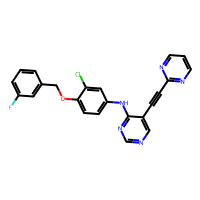
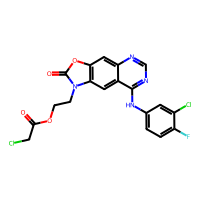
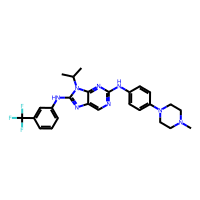
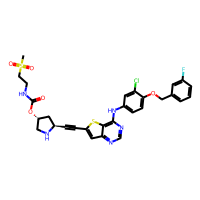
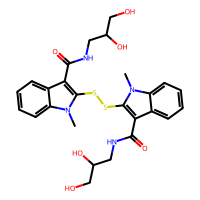
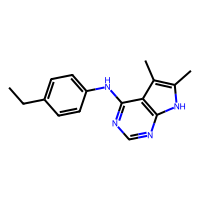
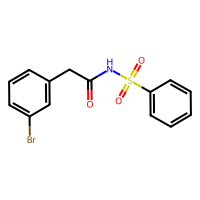
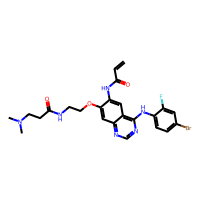
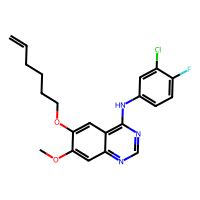
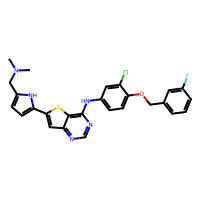

In [12]:
# compound activity
df["active"]=df['pIC50'].map(lambda x: x>6.3)
PandasTools.RenderImagesInAllDataFrames(True)
df

### Task 2: Machine Learning 

Train a Random Forest model using the data prepared above. Set the random state to 0 for reproducible results. Split your data into 80% training and 20% test data and set the seed to 1234 for reproducible results. 

In [28]:
fps = []
for mol in df["morgan"]:
    fps.append(mol)
    
acts = []
for mol in df["active"]:
    acts.append(mol)

In [29]:
len(fps), len(acts)

(3906, 3906)

In [30]:
# random forest model 
X_train, X_test, y_train, y_test = train_test_split(fps,
                                                    acts,
                                                    test_size=0.2,
                                                    random_state=1234,
                                                    shuffle=True,
                                                    stratify=acts)


# n_estimators can be 100 or 200, choose smallest n at plateau of performance
# max_depth can by optimized (hyper parameter), avoids overfitting of too deep uncommunicable trees
# n_jobs, more comp intensive if higher
cls = RandomForestClassifier(n_estimators=200,
                             max_depth=5,
                             oob_score=True,
                             random_state=0,
                             n_jobs=4)


RandomForestClassifier(max_depth=5, n_estimators=200, n_jobs=4, oob_score=True,
                       random_state=0)

In [34]:
cls.fit(X_train,y_train)
y_preds=cls.predict(X_test)
probs = cls.predict_proba(X_test)

To evaluate your model, calculate the accuracy, AUC, sensitivity, and specificity values (for sensitivity and specificity search for the sklearn function recall_score).

In [60]:
sens =  metrics.precision_recall_fscore_support(y_test,y_preds,pos_label=1,average='binary')
spec = metrics.precision_recall_fscore_support(y_test,y_preds,pos_label=0,average='binary')
# 1st term precision, 2nd term recall


In [69]:
# model evaluation
from sklearn import metrics
from scipy import stats

def evaluate_model_performance(preds,probs,y):
    res = dict(confusion = metrics.confusion_matrix(y,preds),
    accuracy = metrics.accuracy_score(y,preds),
    kappa = metrics.cohen_kappa_score(y,preds),
    mcc = metrics.matthews_corrcoef(y,preds),
    auroc = metrics.roc_auc_score(y,probs[:,1]),
    report = metrics.classification_report(y,preds))

    
    
    return res
    
def show_model_performance(preds,probs,y):
    perf = evaluate_model_performance(preds,probs,y)
    # recall of the positive class is also known as “sensitivity”; 
    # recall of the negative class is “specificity”.
    sens =  metrics.precision_recall_fscore_support(y,preds,pos_label=1,average='binary')
    spec = metrics.precision_recall_fscore_support(y,preds,pos_label=0,average='binary')
    
    output = f'''
    Accuracy: {perf['accuracy']:.3f} Kappa: {perf['kappa']:.3f} MCC: {perf['mcc']:.3f} AUROC: {perf['auroc']:.3f}
    Confusion matrix:
    {perf['confusion']}
    Report:
    {perf['report']}
    Sensitivity:
    {sens[1]:.3f}
    Specificity:
    {spec[1]:.3f}

    
    '''
    
    
    print(output)

In [70]:
show_model_performance(y_preds, probs, y_test)


    Accuracy: 0.797 Kappa: 0.579 MCC: 0.584 AUROC: 0.857
    Confusion matrix:
    [[234 105]
 [ 54 389]]
    Report:
                  precision    recall  f1-score   support

       False       0.81      0.69      0.75       339
        True       0.79      0.88      0.83       443

    accuracy                           0.80       782
   macro avg       0.80      0.78      0.79       782
weighted avg       0.80      0.80      0.79       782

    Sens:
    0.878
    Spec:
    0.690

    
    


### Task 3: Compound Filtering 

Filter the compounds in "data/test_compounds_EGFR.csv" down to 20 compounds. For this, you can combine I) classical similarity searches/substructure searches II) predictions via a machine learning approach, III) filtering criteria based on molecular properties (Lipinski's rule of five) IV) and/or clustering. Note that you will predict the binding affinity and binding mode of your selected subset via docking for further filtering. It might be wise to have a selected set of diverse compounds, e.g. obtained using different selection criteria.


* Read in the data containing the unknown compounds. Start your filtering with an activity prediction using the trained random forest model. If you have time, feel free to try out different models (e.g. what you have seen in previous sessions) and choose your favorite one for the filtering. 


,Unnamed: 0,chembl_id,canonical_smiles,molecule,morgan
0,1927,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c4ccccc24)cc1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,212,CHEMBL107472,CNc1ncc2C=C(C(=O)N(C)c2n1)c3c(Cl)cccc3Cl,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3089,CHEMBL1077068,CC1=C(C(NC(=N1)Nc2ccc(cc2)S(=O)(=O)Nc3ncccn3)c...,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3126,CHEMBL1088240,COc1cc(Nc2c(cnc3cc(\C=C\CCN4CCN(C)CC4)c(OC)cc2...,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,3125,CHEMBL1092382,CCC(=O)Nc1ccc2nccc(Nc3cccc(Br)c3)c2c1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
1046,2307,CHEMBL94061,CN(C)C\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1047,1303,CHEMBL94123,Brc1cccc(Nc2ncnc3ccc(NC(=O)\C=C\N4CCOCC4)cc23)c1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1048,1089,CHEMBL94275,[O-][N+](=O)c1ccc2c(Nc3cccc(Br)c3)ncnc2c1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1049,120,CHEMBL95320,COCCOc1cc2ncc(C#N)c(Nc3cccc(c3)C#C)c2cc1OCCOC,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."

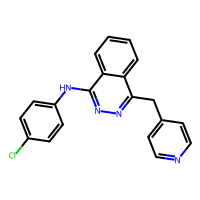
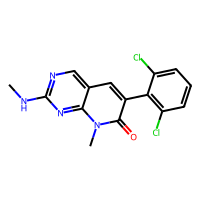
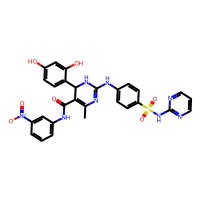
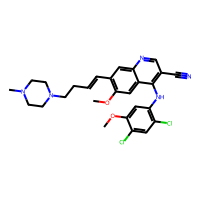
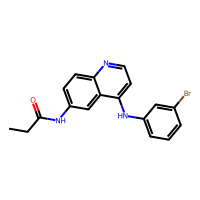
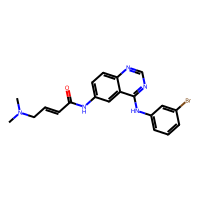
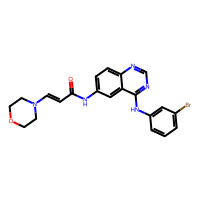
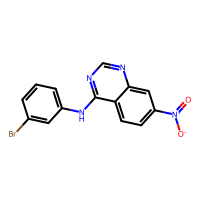
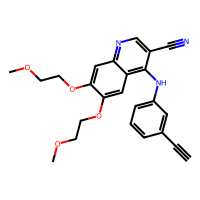
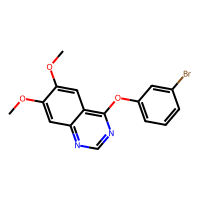

In [199]:
df3=pd.read_csv('./data/test_compounds_EGFR.csv')
df=df3.dropna(axis=0,how='all')
# morgan fingerprint 
df["molecule"]=df["canonical_smiles"].map(lambda x: Chem.MolFromSmiles(x) )
df['morgan'] = df['molecule'].map(lambda x:GetMorganFingerprintAsBitVect(x,2))
df

In [223]:
X_test= []
for name in df["morgan"]:
    X_test.append(name)

In [224]:
# apply RF model to unknown compounds and filter 

y_preds=cls.predict(X_test)
probs = cls.predict_proba(X_test)

In [225]:
df["pred_activity"]=y_preds
df["prob_activity0"]=probs[:,0]
df["prob_activity1"]=probs[:,1]


In [226]:
filt_df=df.where(df["pred_activity"]==True).dropna(how='all',axis=0)
filt_df.shape

(685, 8)

- Now filter the remaining compounds using one of the previously mentioned options: 
    - similarity / substructure search 
    - filtering based on Lipinski's rule 
    - clustering 

### 1st filt Lipinski RO5

Molecular weight <= 500

LogP <= 5.0

H-bond donor count <= 5

H-bond acceptor count <= 10

In [227]:
# further filtering by Lipinski
filt_df["MW"]=filt_df["molecule"].apply(Descriptors.MolWt)
filt_df["logP"]=filt_df["molecule"].map(lambda x: Chem.Crippen.MolLogP(x))
filt_df["HA"]=filt_df["molecule"].map(lambda x: Chem.Lipinski.NumHAcceptors(x))
filt_df["HD"]=filt_df["molecule"].map(lambda x: Chem.Lipinski.NumHDonors(x))



In [228]:


filt_df=filt_df[(filt_df['logP'] <= 5) & 
                (filt_df['MW'] <=500 )&
                (filt_df['HA'] <=10 ) &
                (filt_df['HD'] <=5 )].copy().dropna(how='all',axis=0)
filt_df.shape

(346, 12)

,Unnamed: 0,chembl_id,canonical_smiles,molecule,morgan,pred_activity,prob_activity0,prob_activity1,MW,logP,HA,HD
12,3152.0,CHEMBL1097368,C(Cc1cc2c(Nc3ccc4[nH]ccc4c3)ncnc2[nH]1)c5ccccc5,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.387467,0.612533,353.429,4.96800,3,3
16,511.0,CHEMBL114490,COc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)\...,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.461883,0.538117,453.905,4.70748,6,2
21,1121.0,CHEMBL116748,[O-][N+](=O)c1ccc2c(NCc3ccccc3)ncnc2c1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.405921,0.594079,280.287,3.15010,5,1
22,1069.0,CHEMBL116919,COc1ccc(CNc2ncnc3ccccc23)cc1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.429104,0.570896,265.316,3.25050,4,1
31,3170.0,CHEMBL1172957,NS(=O)(=O)c1ccc(Nc2nc(nc3[nH]cnc23)N4CCOCC4)cc1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.493434,0.506566,375.414,0.58050,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1045,1198.0,CHEMBL94019,COc1cc2ncnc(NC3CCc4ccccc34)c2cc1OC,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.348142,0.651858,321.380,3.74640,5,1
1046,2307.0,CHEMBL94061,CN(C)C\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.252621,0.747379,426.318,4.19220,5,2
1047,1303.0,CHEMBL94123,Brc1cccc(Nc2ncnc3ccc(NC(=O)\C=C\N4CCOCC4)cc23)c1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.260448,0.739552,454.328,3.92030,6,2
1048,1089.0,CHEMBL94275,[O-][N+](=O)c1ccc2c(Nc3cccc(Br)c3)ncnc2c1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.278402,0.721598,345.156,4.04410,5,1

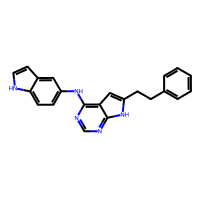
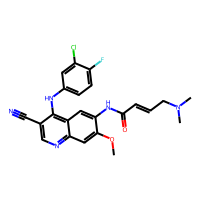
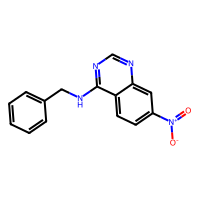
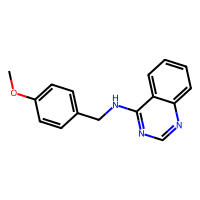
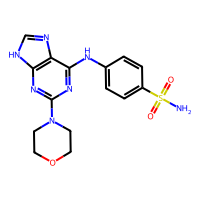
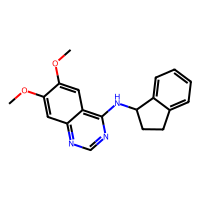
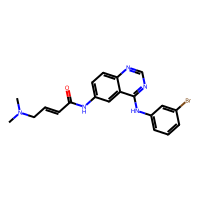
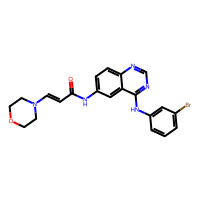
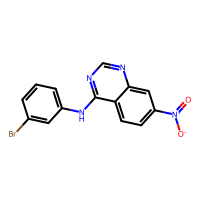
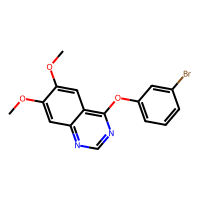

In [229]:
filt_df

In [230]:
X=[]
for m in filt_df['morgan']:
    X.append(m)

### 2nd filt similarity to gefitinib and kmeans cluster

,Unnamed: 0,chembl_id,canonical_smiles,molecule,morgan,pred_activity,prob_activity0,prob_activity1,MW,logP,HA,HD,similarity
329,381.0,CHEMBL24137,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCCCN4CCOCC4,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",True,0.250365,0.749635,446.910,4.2756,7,1,0.764706
334,4542.0,CHEMBL2425088,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCN4CC5(CCO...,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",True,0.204152,0.795848,444.894,4.0280,7,1,0.708333
739,5793.0,CHEMBL3918330,C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC...,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",True,0.180593,0.819407,499.974,4.7816,7,2,0.701299
310,4425.0,CHEMBL2334001,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCO,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",True,0.207600,0.792400,363.776,3.5456,6,2,0.692308
309,4426.0,CHEMBL2333999,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCBr,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",True,0.202705,0.797295,426.673,4.9482,5,1,0.692308
...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,5545.0,CHEMBL3758376,CN(C)CCNC(=O)c1ccc(cc1)c2cc3c(N[C@H](CO)c4cccc...,,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",True,0.354718,0.645282,461.591,3.7952,7,3,0.142857
343,4598.0,CHEMBL2437463,C=CC(=O)Nc1cccc(c1)N2C(=O)C=Nc3cnc(Nc4ccc(cc4)...,,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.335788,0.664212,467.533,4.0341,8,2,0.141509
575,5165.0,CHEMBL3604912,C=CC(=O)Nc1cccc(c1)c2nc(Nc3cc[nH]n3)c4ccccc4n2,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.446406,0.553594,356.389,3.8880,5,3,0.141414
604,6417.0,CHEMBL3647970,CN(C)C\C=C\C(=O)N1CCC[C@H](C1)n2nc(c3ccc(Oc4cc...,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.479929,0.520071,497.603,4.1491,8,1,0.112069

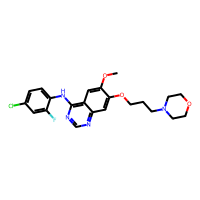
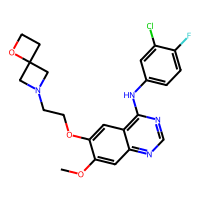
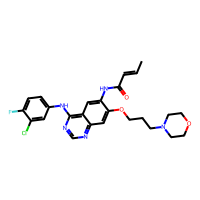
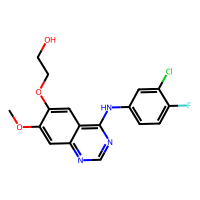
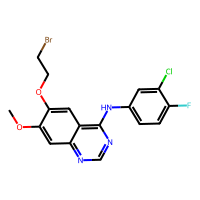
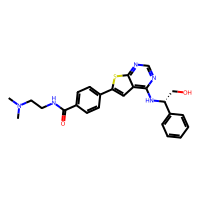
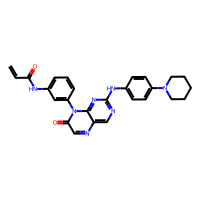
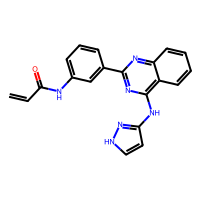
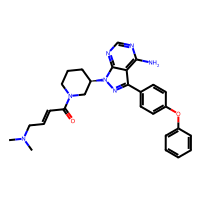
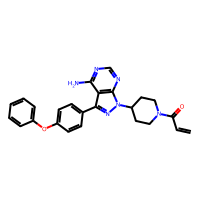

In [231]:
# similarity filter to fda approved egfr inhib
gefitinib = Chem.MolFromSmiles("COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1")
def get_dataframe_with_x_most_similar_compounds_to_query(query, mol_df, molCol='molecule', x=filt_df.shape[0]):
    query_fp = GetMorganFingerprintAsBitVect(query,2)
    mol_df['similarity'] = mol_df['morgan'].map(lambda x:DataStructs.TanimotoSimilarity(query_fp, x))
    mol_df.sort_values(['similarity'], ascending=False, inplace=True)
    return mol_df[:x]

filt_df = get_dataframe_with_x_most_similar_compounds_to_query(gefitinib, filt_df)
filt_df

In [232]:
# by kmeans clustering
from sklearn.cluster import KMeans
clus=14
kmeans = KMeans(n_clusters=clus)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
# cluster labels (0, 1, 2, or 3). the number itself is arbitrary
print(y_kmeans)

/Users/dimei.wu/mambaforge/envs/py310_aisem2023/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[ 3  1  6  6  3  3  6  3  4  3  3 10  3  3  0  4  6  6 11  4  4  4  0 10
 10  5 10  4  3  0 10 10  4  4  4  4  0  0 12  3  3  0  4  4  4  4  4  5
  3 10  5 10  6  6 10 12 12  4 12 12  3  5  5  5  5  5  1  1  4  1  1 13
  4  3  0 10  7  7  7  7 10  4  1  1  8 10  1  1  6  5  1  1  1  8  8  8
  8  1 12 12 12 12  5  5  5  1 12  3 12  1  9  9  9  9  9  9 10  1  1  1
  1  4  4  4  4  1  4  4  1  4  3  5  5  5  3  1  1  5  0  3 10 10 10 10
 10 10 10  1  4  1  1  5 13 13 13 13 13 13 13 13 13 13 13  5  4 10 10 10
  3  4 10  3  8  3  6  3  4  4 10  1  4  5  5  0  0  5  0 12  4  6  6  4
  4  4 10  1  5  5  5 10  1  1  1 10  1 11 11  4  1  1  4  3  7  8  8  4
  4 12  6  6  6  5  6  7  0  0  0  0  7  7  7  2  2  2  2  2  2  2  0  1
  0 10  1  1  5  1  1  7  7  1 10  1 12  1  5 13  5  5 12 12 12  5 12 12
  6  1 10 13 10  5  6  6 12 12  4 12  9  9 10 10  4 10  9 10  5  4  3  9
  3  4  4  3 10  4 12  3  3  4  4  1  4  4  3 10  3  3  4 10  1  4 12  5
  3  3  4  4  5  4  5  1  1  1  5  1  1  5  5  1  1

In [233]:
len(np.where(y_kmeans==0)[0]),len(np.where(y_kmeans==1)[0]),len(np.where(y_kmeans==2)[0]),len(np.where(y_kmeans==3)[0]),



(17, 53, 7, 37)

In [234]:
len(y_kmeans),filt_df.shape

(346, (346, 13))

In [235]:
filt_df["cluster"]=y_kmeans

/var/folders/x4/lmdggv1j4979s5x0zkhx0q9m0000gp/T/ipykernel_61019/3529368589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df["cluster"]=y_kmeans


In [242]:
# calc average prob_activity1 for each cluster
prob_list=[]
sim_list=[]
for x in range(0,clus):
    filtfilt_df=filt_df[filt_df["cluster"]==x]
    norm_prob1=filtfilt_df["prob_activity1"].mean()
    norm_sim=filtfilt_df["similarity"].mean()
    print( norm_sim)

    prob_list.append(norm_prob1)
    sim_list.append(norm_sim)
max(prob_list), prob_list.index(max(prob_list)),max(sim_list),sim_list.index(max(sim_list))

0.3614001494780711
0.2973728167845752
0.24605062998982366
0.3619953229326699
0.32905061981547384
0.2815467376422291
0.39089394632025437
0.30341485331908963
0.33633682010256793
0.2926082302454044
0.30887013652009326
0.3756433904259991
0.3023729604021656
0.29416059191616944


(0.7639582364832638, 11, 0.39089394632025437, 6)

Highest active prob is not same cluster as highest similarity. Whatever we will choose highest active prob cluster and later cutoff with similarity.


In [243]:
filt_df[filt_df["cluster"]==prob_list.index(max(prob_list) ) ].shape

(3, 14)

* draw the set of selected compounds

/var/folders/x4/lmdggv1j4979s5x0zkhx0q9m0000gp/T/ipykernel_61019/1890050242.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.sort_values(['similarity'], ascending=False, inplace=True)


,Unnamed: 0,chembl_id,canonical_smiles,molecule,morgan,pred_activity,prob_activity0,prob_activity1,MW,logP,HA,HD,similarity,cluster
463,4750.0,CHEMBL3219508,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1B(O)O,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.229356,0.770644,347.542,1.8543,6,3,0.606061,11
802,6730.0,CHEMBL4071058,CC(C)(C)OC(=O)NCC(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3...,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.258051,0.741949,472.343,4.5991,6,3,0.260870,11
268,1773.0,CHEMBL205047,OCc1nc(cs1)C#Cc2cncnc2Nc3ccc(OCc4cccc(F)c4)c(C...,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.220718,0.779282,466.925,4.9403,7,2,0.260000,11

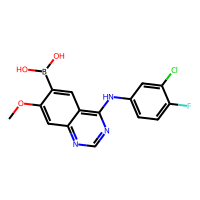
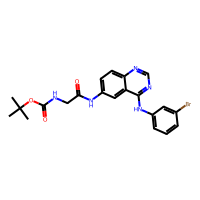
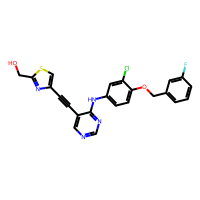

In [245]:
# draw molecules
final_df=filt_df[filt_df["cluster"]==prob_list.index(max(prob_list) ) ]
final_df.sort_values(['similarity'], ascending=False, inplace=True)
final_df

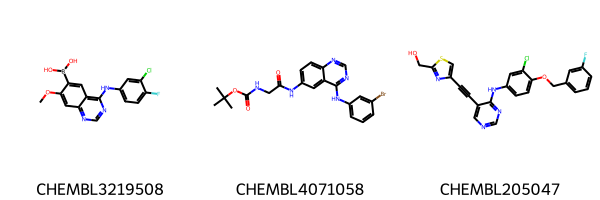

In [246]:
PandasTools.FrameToGridImage(final_df.head(20), column='molecule', legendsCol='chembl_id')


* write them to disk

In [247]:
# save selected compounds
final_df.to_csv('final_filtered_df_3.csv')